# Packing the process in functions

In [1]:
def data_quality(x):
    
    
    #modify types
    temp = x.astype({'month': 'O', 'wday': 'O'})
    
    # nulls
    temp.event_name_1.fillna('No_event', inplace=True)
    
    # impute by mode
    temp.sell_price = temp.groupby('item_id')['sell_price'].transform(lambda x: x.fillna(x.mode()[0]))

    return temp
    

In [2]:
def create_variables(df):
    
    #### Intermitent demand
    
    def out_of_stock(sales, n = 5):
        zero_sales = pd.Series(np.where(sales == 0,1,0))
        num_zeros = zero_sales.rolling(n).sum()
        out_of_stock = np.where(num_zeros == n,1,0)
        return(out_of_stock)
    
    df = df.sort_values(by = ['store_id','item_id','date'])
    df['out_of_stock_3'] = df.groupby(['store_id','item_id']).sales.transform(lambda x: out_of_stock(x, 3))
    df['out_of_stock_7'] = df.groupby(['store_id','item_id']).sales.transform(lambda x: out_of_stock(x, 7))
    df['out_of_stock_15']= df.groupby(['store_id','item_id']).sales.transform(lambda x: out_of_stock(x, 15))

    #### LAGS
    
    def create_lags(df, variable, num_lags = 7):
        # create object dataframe
        lags = pd.DataFrame()

        # create lags
        for each in range(1,num_lags+1):
            lags[variable + '_lag_'+str(each)] = df[variable].shift(each)

        #return lags dataframe
        return lags

    # sell price ---> 7 days lag
    lags_sell_price_df = (df.groupby(['store_id', 'item_id'])
                            .apply(lambda x: create_lags(df = x, variable = 'sell_price', num_lags= 7), include_groups=False)
                            .reset_index()
                            .set_index('date'))

    # out_of_stock ---> 1 day lag
    lags_out_of_stock_3_df = (df.groupby(['store_id','item_id'])
                                .apply(lambda x: create_lags(df = x, variable = 'out_of_stock_3', num_lags= 1), include_groups=False)
                                .reset_index()
                                .set_index('date'))
    lags_out_of_stock_7_df = (df.groupby(['store_id','item_id'])
                                .apply(lambda x: create_lags(df = x, variable = 'out_of_stock_7', num_lags= 1), include_groups=False)
                                .reset_index()
                                .set_index('date'))
    lags_out_of_stock_15_df = (df.groupby(['store_id','item_id'])
                                .apply(lambda x: create_lags(df = x, variable = 'out_of_stock_15', num_lags= 1), include_groups=False)
                                .reset_index()
                                .set_index('date'))

    # sales ----> 15 days lag
    lags_sales_df = (df.groupby(['store_id','item_id'])
                        .apply(lambda x: create_lags(df = x, variable = 'sales', num_lags= 15))
                        .reset_index()
                        .set_index('date'))


    #### ROLLING WINDOWS
    
    
    def local_min(df, variable, num_periods = 7):
        lmin = pd.DataFrame()

        for each in range(2,num_periods+1):
            lmin[variable+'_minlocal_'+str(each)] = df[variable].shift(1).rolling(each).min()

        return lmin

    def local_max(df, variable, num_periods = 7):
        lmax = pd.DataFrame()

        for each in range(2, num_periods+1):
            lmax[variable+'_maxlocal_'+str(each)] = df[variable].shift(1).rolling(each).max()

        return lmax

    def local_mean(df, variable, num_periods = 7):
        lmean = pd.DataFrame()

        for each in range(2,num_periods+1):
            lmean[variable+'_meanlocal_'+str(each)] = df[variable].shift(1).rolling(each).mean()

        return lmean


    min_local_df = (df.groupby(['store_id','item_id'])
                  .apply(lambda x: local_min(df = x, variable = 'sales', num_periods= 15))
                  .reset_index()
                  .set_index('date'))
    mean_local_df = (df.groupby(['store_id','item_id'])
                        .apply(lambda x: local_mean(df = x, variable = 'sales', num_periods= 15))
                        .reset_index()
                        .set_index('date'))
    max_local_df = (df.groupby(['store_id','item_id'])
                        .apply(lambda x: local_max(df = x, variable = 'sales', num_periods= 15))
                        .reset_index()
                        .set_index('date'))

    #### JOIN DATAFRAMES
    
    df_joined = pd.concat([df,
                      lags_sell_price_df,
                      lags_out_of_stock_3_df,
                      lags_out_of_stock_7_df,
                      lags_out_of_stock_15_df,
                      lags_sales_df,
                      min_local_df,
                      mean_local_df,
                      max_local_df], axis = 1)

    # delete duplicated columns
    df_joined = df_joined.loc[:,~df_joined.columns.duplicated()]
    df_joined.dropna(inplace=True)
    
    # delete original variables, we already have used them to build new variables
    
    df_joined.drop(columns = ['sell_price','out_of_stock_3','out_of_stock_7','out_of_stock_15'],
                  inplace=True)
    
    # Create a single variable for the product
    df_joined.insert(loc=0, column = "product", value = df_joined.store_id + '_' + df_joined.item_id)
    df_joined = df_joined.drop(columns = ['store_id','item_id'])
    
    
    return df_joined
    
    

In [3]:
def transform_variables(x,y=None,mode = 'training'):
    
    '''
    This works both for training and for execution
    Parameter y is optional because isn't used in execution
    
    
    Training: apply fit_transform and saves the objects
    Execution: loads the objects and applies only transform
    '''
    
    x.reset_index(inplace = True)

    # ENCODERS
    path_ohe = '../../04_Models/ohe_retail.pickle' 
    path_te  = '../../04_Models/te_retail.pickle' 
    
    
    #ONE HOT ENCODING
    var_ohe = ['event_name_1']
    if mode == 'training':
        
        ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')
        
        
        ohe_x = ohe.fit_transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns = ohe.get_feature_names_out())
        with open(path_ohe, mode='wb') as file:
            pickle.dump(ohe, file)
    else:
        # execution mode
        with open(path_ohe, mode='rb') as file:
            ohe = pickle.load(file)
        ohe_x = ohe.transform(x[var_ohe])
        ohe_x = pd.DataFrame(ohe_x, columns = ohe.get_feature_names_out())

    #TARGET ENCODING    
    var_te = ['month','wday','weekday']
    if mode == 'training':
        
        #Make sure Y is as long as X
        y.reset_index(inplace = True, drop = True)
        y = y.loc[y.index.isin(x.index)]
        
        # Training mode
        te = TargetEncoder(min_samples_leaf=100, return_df = False)
        te_x = te.fit_transform(x[var_te], y = y)
        names_te = [variable + '_te' for variable in var_te]
        te_x = pd.DataFrame(te_x, columns = names_te)
        with open(path_te, mode='wb') as file:
            pickle.dump(te, file)
    else:
        # training mode
        with open(path_te, mode='rb') as file:
            te = pickle.load(file)
        te_x = te.transform(x[var_te])
        names_te = [variable + '_te' for variable in var_te]
        te_x = pd.DataFrame(te_x, columns = names_te)
    
      
    # CLEANUP
    #eliminate originals
    x = x.drop(columns=['event_name_1','month','wday','weekday'])
    # include the other dataframes
    x = pd.concat([x,ohe_x,te_x], axis=1).set_index('date')

    # output
    return(x)

In [4]:
def variable_preselection(x,y):
    
        # only during training
    
    #Delete product and index
    x.reset_index(drop = True,inplace = True)
    x.drop(columns='product',inplace = True)
    
    # make sure equal lenght
    y = y.loc[y.index.isin(x.index)]
    

    mutual_selector = mutual_info_regression(x,y)
    pos_var_limit = 70
    ranking_mi = pd.DataFrame(mutual_selector, index = x.columns).reset_index()
    ranking_mi.columns = ['variable','importance_mi']
    ranking_mi = ranking_mi.sort_values(by = 'importance_mi', ascending = False)
    ranking_mi['ranking_mi'] = np.arange(0,ranking_mi.shape[0])
    enter_mi = ranking_mi.iloc[0:pos_var_limit].variable
    x_mi = x[enter_mi].copy()

    return(x_mi)

### Modeling

#### Training

In [5]:
def model_each(x_product, y):
          
        # individual modeling
        # gets x and y of a product
        # finds optimal parameters 
        # returns best model
        
        
    # exclude product as model variable
    var_to_model = x_product.columns.to_list()[2:]
    
    #Define cross validation
    time_cv = TimeSeriesSplit(3, test_size = 8)
    
    # define algorithm pipe
    pipe = Pipeline([('algorithm', HistGradientBoostingRegressor())])
    
    grid = [ 
         {'algorithm': [HistGradientBoostingRegressor()]#, # after some tries, default works the best
#         'algorithm__learning_rate': [0.01,0.025,0.05,0.1],
#         'algorithm__max_iter': [50,100,200],
#         'algorithm__max_depth': [None, 5,10,20],
#         'algorithm__min_samples_leaf': [20, 500],
#         'algorithm__l2_regularization': [0,0.25,0.5,0.75,1]
        }
                       
    ]
           
    #create the models
    random_search = RandomizedSearchCV(estimator = pipe,
                                       param_distributions = grid, 
                                       n_iter = 1, #30, 
                                       cv = time_cv, 
                                       scoring = 'neg_mean_absolute_error', 
                                       verbose = 0,
                                       n_jobs = -1)

    
    model = random_search.fit(x_product[var_to_model],y)
    
    final_model = model.best_estimator_.fit(x_product[var_to_model],y)
    
    return(final_model)


In [6]:
def launch_training(df):
    
        # goes through all products
        # models them
        # creates a list with all the models for all the producs

        # gets the dataframe clean and segmented by product
        
        # doesn't return anything, 
        # just saves in disk the trained object with all the models
        
        
    products_list = list(df['product'].unique())
    models_list = []
    
    for each in products_list:

        product = each #[0]
        target = 'sales'
        
        
        
        x = df.loc[df['product'] == product].drop(columns=target).copy()
        y = df.loc[df['product'] == product,'sales'].copy()

        x = transform_variables(x,y)
        x = variable_preselection(x,y)

        # Call to model
        model = model_each(x,y)
        
        # add final model to the list
        models_list.append((product,model))
    
    #Save trained models list
    
    models_path = '../../04_Models/models_list_retail.pickle'
    with open(models_path, mode='wb') as file:
        pickle.dump(models_list, file)
    
    print('Successfully trained')
        

#### Execution

In [7]:

def launch_execution(df):
    
    # makes the forecast for each product
    # but only one day
    
    # gets the new dataset to predict
    # needs to have the structure of DataForProduction.csv, 
    # from the Validation folder
   

    
    #LOAD THE MODELS
    models_path = '../../04_Models/models_list_retail.pickle'
    with open(models_path, mode='rb') as file:
        models_list = pickle.load(file)
    
    predictions_df = pd.DataFrame(columns=['date','product','sales','prediction'])
    
    for each in range(0,len(models_list)):

        product = models_list[each][0]
        model = models_list[each][1]
        variables = model[0].feature_names_in_
        target = 'sales'
        
        
        x = df.loc[df['product'] == product].drop(columns=target).copy()
        y = df.loc[df['product'] == product,'sales'].copy()

        date = df.reset_index().copy()
        date = date.loc[date['product'] == product,'date'].values

        #var transformation
        x = transform_variables(x, mode = 'execution')
        
        #var selection
        x = x[variables]
        
        #Calculate predictions
        predictions = pd.DataFrame(data={'date': date,
                                          'product': product,
                                          'sales': y,
                                          'prediction': model.predict(x)})

        predictions['prediction'] = predictions.prediction.astype('int')

        predictions_df = pd.concat([predictions_df,predictions])
    
    predictions_df = predictions_df.loc[predictions_df.index == predictions_df.index.min()]  
    return(predictions_df)



In [8]:
def recursive_forecast(x):
    
    
    # x is the dataframe with the DataForProduction.csv structure

    # to apply the recursivity:
        # - predict the first day (15 days from the oldest)
        # - saves the prediction in the day and deletes the oldest day
        # - the next iteration is going to predict the next day

    
    for each in range(0,8):
        step1_df = data_quality(x)
        step2_df = create_variables(step1_df)
        
        #predict
        f = launch_execution(step2_df)
        f['store_id'] = f['product'].str[:4]
        f['item_id'] = f['product'].str[5:]

        # Update the sales data with the prediction
        x.loc[(x.index.isin(f.date)) & (x.store_id.isin(f.store_id)) & (x.item_id.isin(f.item_id)),'sales'] = f.prediction
                                                              
        # Delete the oldest day in x
        x = x.loc[x.index != x.index.min()]
        
    return(x)

# PROCESS

### Retraining

In [9]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

from sklearn.feature_selection import mutual_info_regression

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import Pipeline

from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


#Load data
data_path = '../../02_Data/03_Work/work.csv'
df = pd.read_csv(data_path,sep=',',parse_dates=['date'],index_col='date')


final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']

df = df[final_variables]


step1_df = data_quality(df)
step2_df = create_variables(step1_df)


launch_training(step2_df)

Successfully trained


### Evaluation

In [82]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")



#Load data
data_path = '../../02_Data/02_Validation/validation.csv'
df = pd.read_csv(data_path,sep=',',parse_dates=['date'],index_col='date')


#Select used variables
final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']


df = df[final_variables]

step1_df = data_quality(df)
step2_df = create_variables(step1_df)

forecast_1day = launch_execution(step2_df)

print('MAE = ', mean_absolute_error(forecast_1day['sales'],forecast_1day['prediction']))

forecast_1day

MAE =  5.9


,date,product,sales,prediction
2015-12-16,2015-12-16,CA_3_FOODS_3_090,0,-9
2015-12-16,2015-12-16,CA_3_FOODS_3_120,52,54
2015-12-16,2015-12-16,CA_3_FOODS_3_202,20,14
2015-12-16,2015-12-16,CA_3_FOODS_3_252,36,34
2015-12-16,2015-12-16,CA_3_FOODS_3_288,35,22
2015-12-16,2015-12-16,CA_3_FOODS_3_329,64,42
2015-12-16,2015-12-16,CA_3_FOODS_3_555,30,23
2015-12-16,2015-12-16,CA_3_FOODS_3_586,76,62
2015-12-16,2015-12-16,CA_3_FOODS_3_587,29,33
2015-12-16,2015-12-16,CA_3_FOODS_3_714,19,16


#### Evaluate Recursive Forecasting

In [29]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")



#Load data
data_path = '../../02_Data/02_Validation/DataForProduction.csv'
df = pd.read_csv(data_path,sep=',',parse_dates=['date'],index_col='date')
df.index = pd.to_datetime(df.index, format="%d/%m/%Y")


#Select used variables
final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']


df = df[final_variables]


In [33]:
forecast = recursive_forecast(df)

In [31]:
#Load validation data
data_path = '../../02_Data/02_Validation/validation_forecast_8.csv'
val_df = pd.read_csv(data_path,sep=',',parse_dates=['date'],index_col='date')


In [41]:
predict_vs_real = pd.merge(
    forecast[['store_id',"item_id","sales"]],
    val_df[['store_id',"item_id","sales"]],  
    on=["date","item_id", "store_id"],
    how="inner" 
).rename(columns={"sales_x": "predicted_sales", "sales_y":"real_sales"})

predict_vs_real['error'] = abs(predict_vs_real.predicted_sales - predict_vs_real.real_sales)


predict_vs_real

,store_id,item_id,predicted_sales,real_sales,error
date,,,,,
2015-12-24,CA_3,FOODS_3_090,1,0,1
2015-12-24,CA_3,FOODS_3_120,58,44,14
2015-12-24,CA_3,FOODS_3_202,21,39,18
2015-12-24,CA_3,FOODS_3_252,35,32,3
2015-12-24,CA_3,FOODS_3_288,29,28,1
...,...,...,...,...,...
2015-12-31,CA_4,FOODS_3_329,7,6,1
2015-12-31,CA_4,FOODS_3_555,4,5,1
2015-12-31,CA_4,FOODS_3_586,10,11,1


In [42]:
predict_vs_real.error.mean()

8.50625

In [70]:
import matplotlib.pyplot as plt

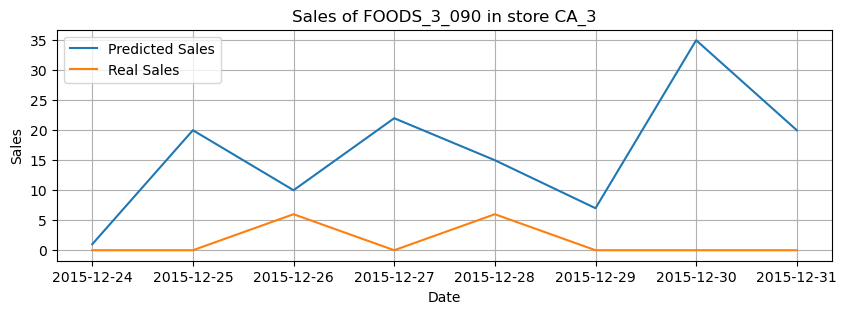

MAE for FOODS_3_090 : 14.75


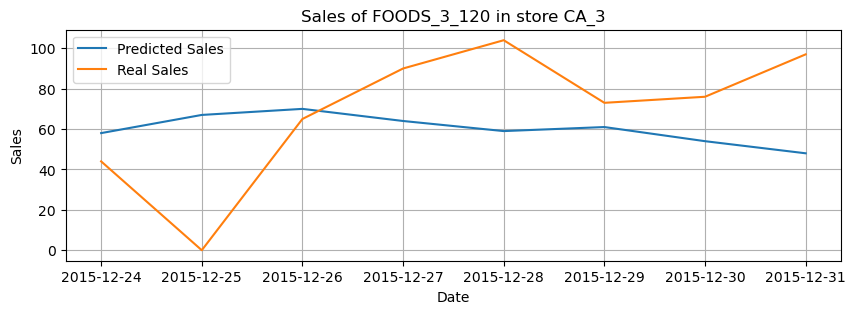

MAE for FOODS_3_120 : 30.0


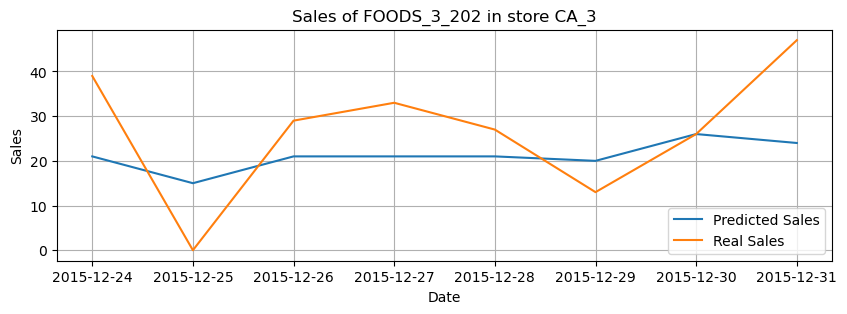

MAE for FOODS_3_202 : 11.125


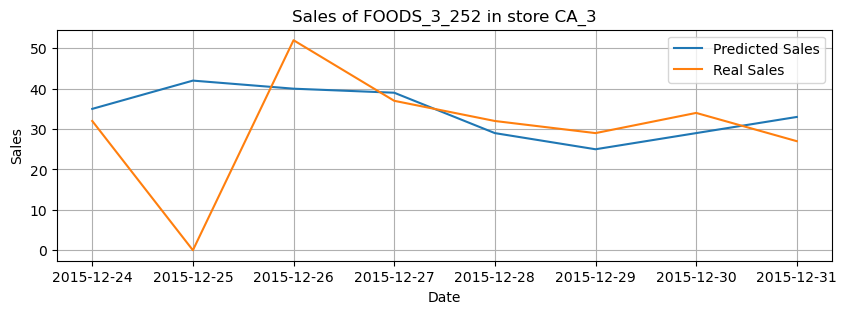

MAE for FOODS_3_252 : 9.625


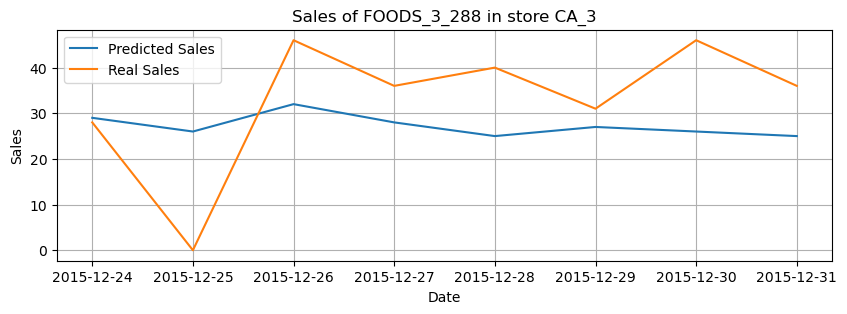

MAE for FOODS_3_288 : 12.375


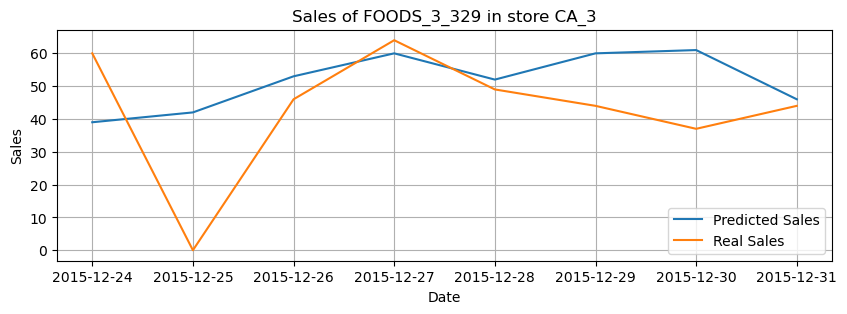

MAE for FOODS_3_329 : 14.875


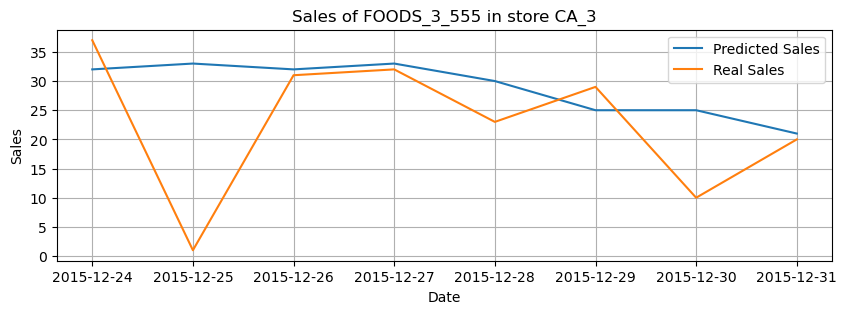

MAE for FOODS_3_555 : 8.25


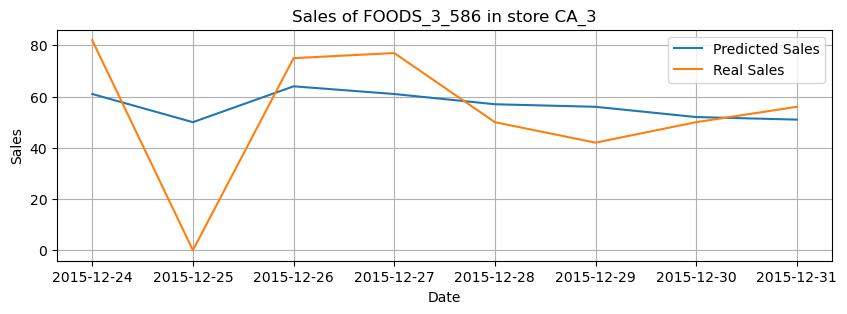

MAE for FOODS_3_586 : 15.75


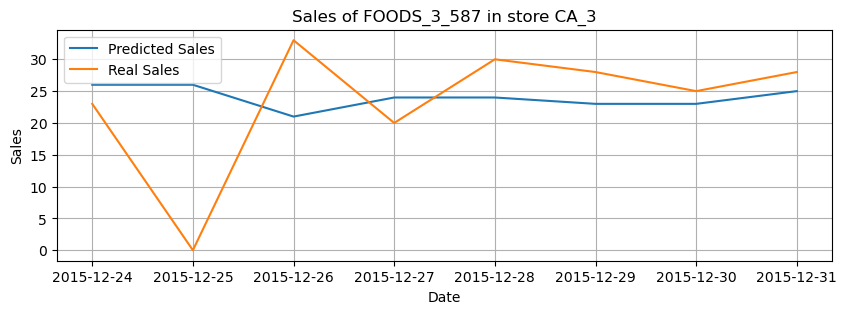

MAE for FOODS_3_587 : 7.625


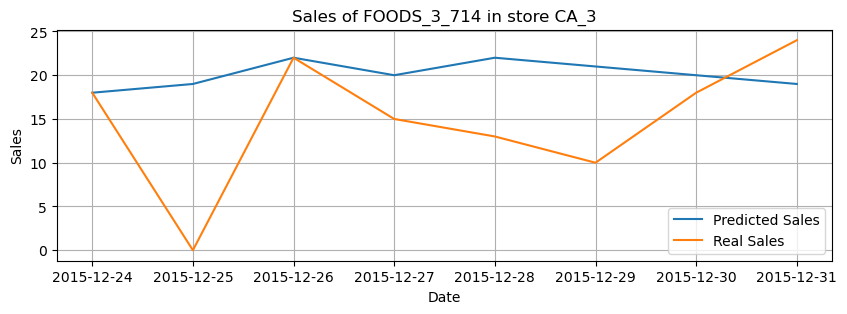

MAE for FOODS_3_714 : 6.375


In [76]:
# Store CA_3

for item in predict_vs_real.item_id.unique():
    val_this_product = predict_vs_real[(predict_vs_real.store_id == "CA_3") & (predict_vs_real.item_id == item)]

    plt.figure(figsize=(10,3))
    plt.plot(val_this_product.predicted_sales, label="Predicted Sales")
    plt.plot(val_this_product.real_sales, label="Real Sales")
    #plt.plot(val_this_product.error, label="Error", color="r")


    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Sales of {item} in store CA_3")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("MAE for",item, ":", val_this_product.error.mean())

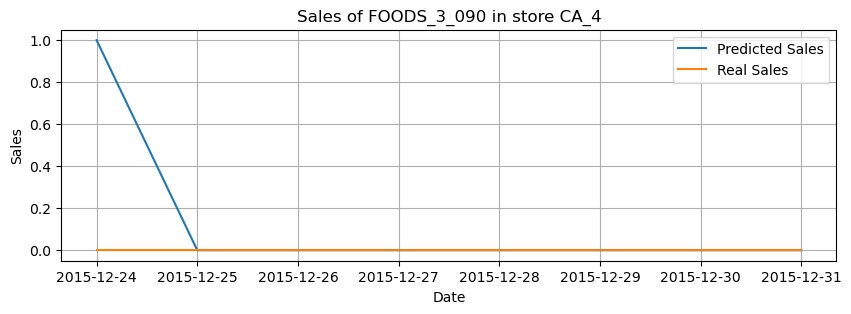

MAE for FOODS_3_090 : 0.125


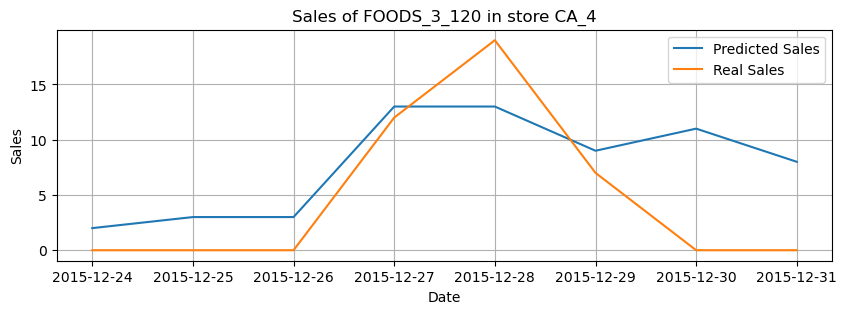

MAE for FOODS_3_120 : 4.5


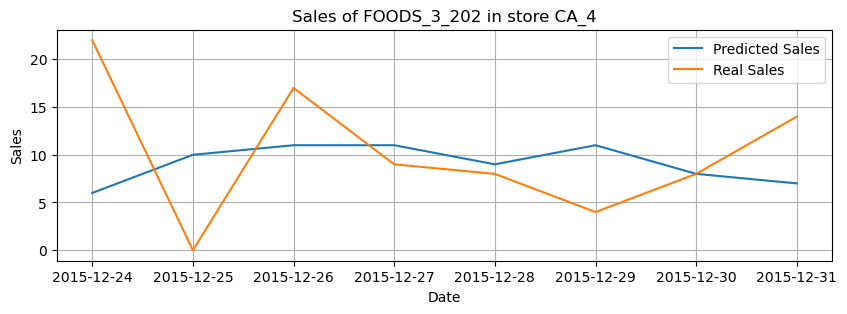

MAE for FOODS_3_202 : 6.125


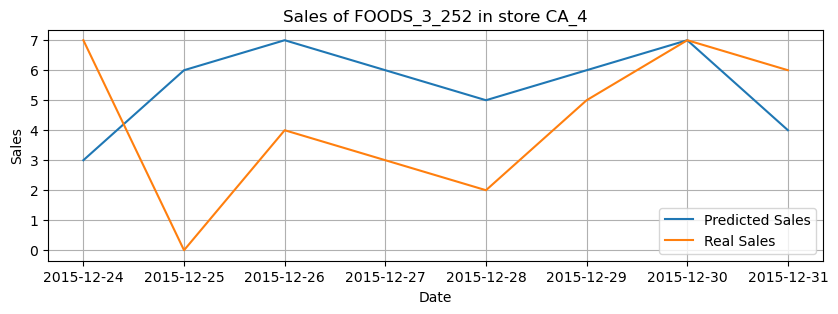

MAE for FOODS_3_252 : 2.75


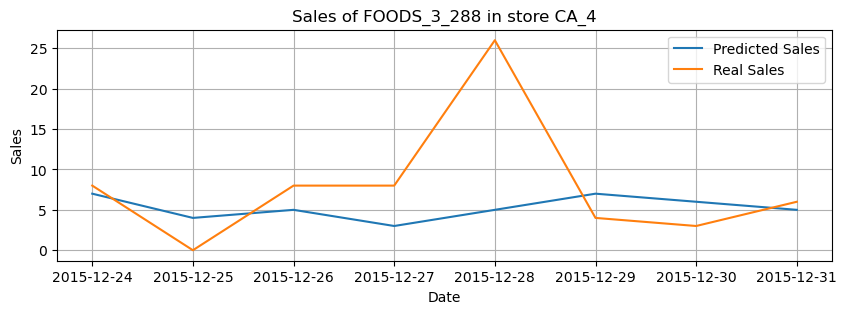

MAE for FOODS_3_288 : 5.125


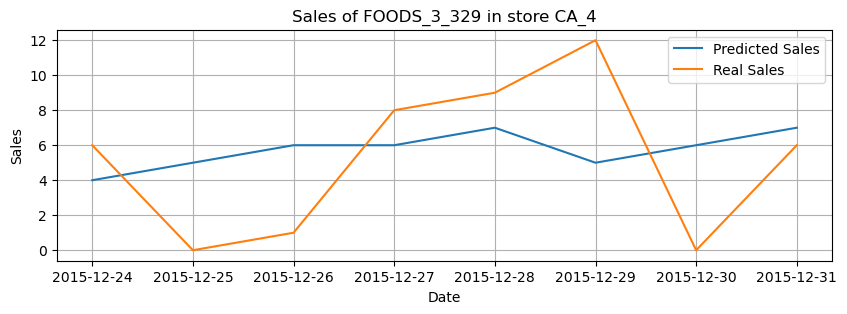

MAE for FOODS_3_329 : 3.75


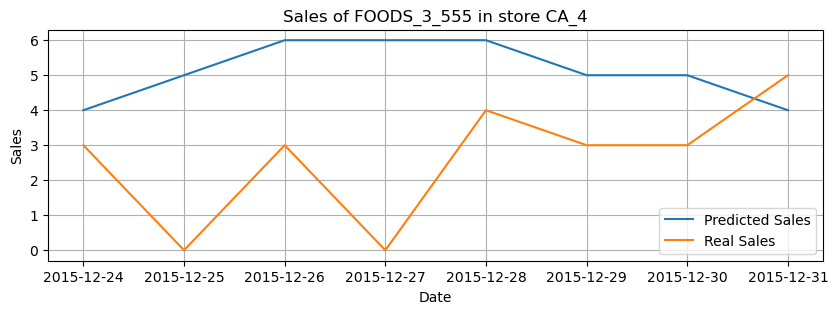

MAE for FOODS_3_555 : 2.75


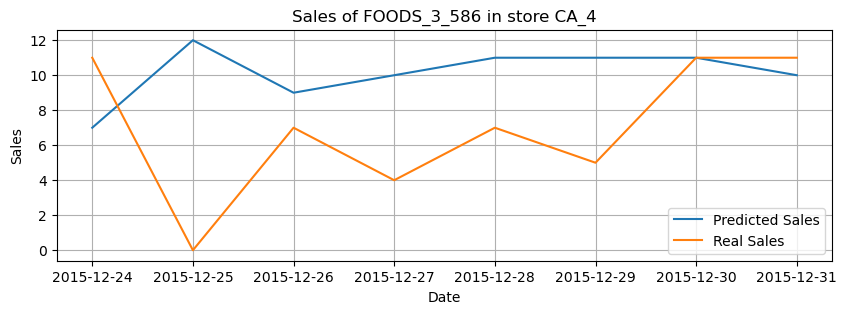

MAE for FOODS_3_586 : 4.375


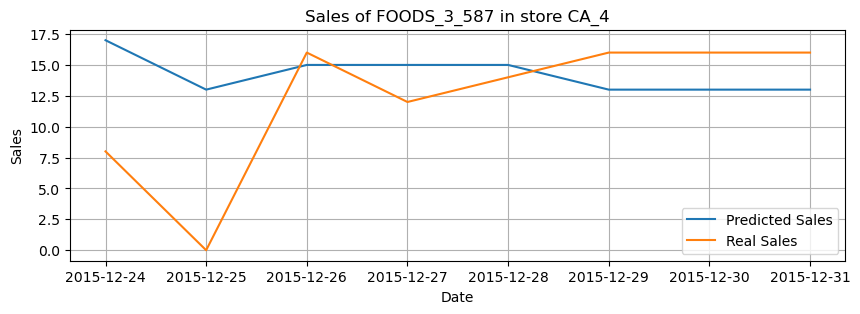

MAE for FOODS_3_587 : 4.5


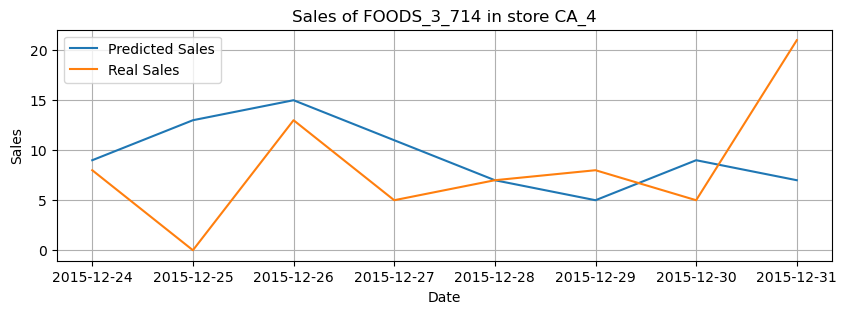

MAE for FOODS_3_714 : 5.375


In [81]:
# Store CA_4

for item in predict_vs_real.item_id.unique():
    val_this_product = predict_vs_real[(predict_vs_real.store_id == "CA_4") & (predict_vs_real.item_id == item)]

    plt.figure(figsize=(10,3))
    plt.plot(val_this_product.predicted_sales, label="Predicted Sales")
    plt.plot(val_this_product.real_sales, label="Real Sales")
    #plt.plot(val_this_product.error, label="Error", color="r")


    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.title(f"Sales of {item} in store CA_4")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("MAE for",item, ":", val_this_product.error.mean())

### Execution

In [21]:
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


#Load the data

data_path = '../../02_Data/02_Validation/DataForProduction.csv'
df = pd.read_csv(data_path,sep=',',parse_dates=['date'],index_col='date')


final_variables = ['store_id',
                     'item_id',
                     'event_name_1',                     
                     'month',
                     'sell_price',                      
                     'wday',
                     'weekday',
                     'sales']
df = df[final_variables]


#Launch prediction
forecast = recursive_forecast(df)

forecast.sort_values(by = ['store_id','item_id'])

,store_id,item_id,event_name_1,month,sell_price,wday,weekday,sales
date,,,,,,,,
17/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,6,Thursday,0
18/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,7,Friday,1
19/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,1,Saturday,0
20/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,2,Sunday,6
21/12/2015,CA_3,FOODS_3_090,NaN,12,1.00,3,Monday,4
...,...,...,...,...,...,...,...,...
27/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,2,Sunday,14
28/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,3,Monday,8
29/12/2015,CA_4,FOODS_3_714,NaN,12,1.58,4,Tuesday,7
